In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '92298637b4404b1783fcf346c6d80b97')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

145

In [6]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

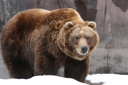

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#399) [Path('bears/grizzly/a849902b-1efb-4481-b802-8d2b8f9f148d.jpg'),Path('bears/grizzly/0601397a-a442-462c-8962-9d5343ba005e.jpg'),Path('bears/grizzly/ab4f2b91-dcfc-4f87-a4a8-8098613b76fe.jpg'),Path('bears/grizzly/bed3e306-adbf-4c17-9e73-1e60eade38c1.jpg'),Path('bears/grizzly/a190501a-73b8-4718-b341-94aaf1b7de40.jpg'),Path('bears/grizzly/ccd08749-d4b3-417e-a53b-d0aab6306ade.jpg'),Path('bears/grizzly/c9c16b4f-2cd5-4f59-adeb-18e1f16897aa.jpg'),Path('bears/grizzly/ed2e9755-7373-43fd-83c8-89ad3f49a9ce.jpg'),Path('bears/grizzly/95589cb2-d2ec-4480-b490-4c27b2a486be.jpg'),Path('bears/grizzly/5e99d27b-9a0a-4903-9fb0-084afaf2ac09.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink);

In [13]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /usr/local/lib/python3.9/dist-packages/fastai/vision/utils.py
Type:      function


In [14]:
class DataLoaders(GetAttr):
    def _init_(self, *loaders): self.loaders = loaders
    def _getitem_(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, self: self[i]) 

In [15]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128))

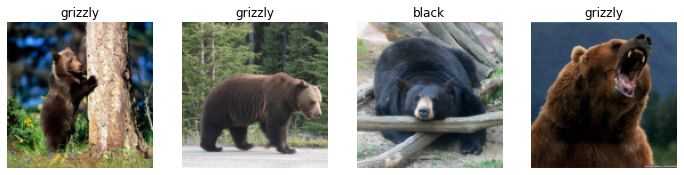

In [16]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

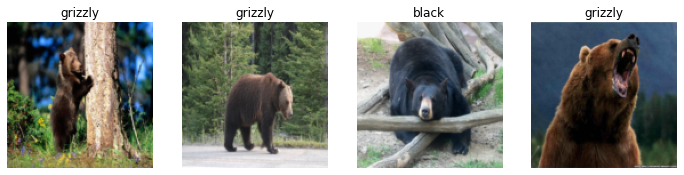

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

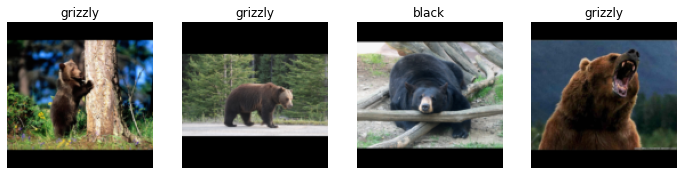

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

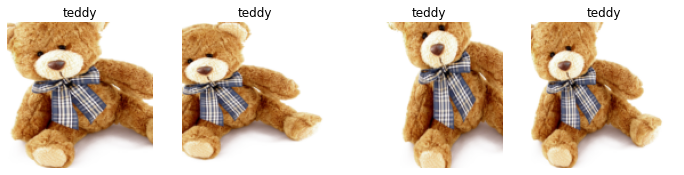

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

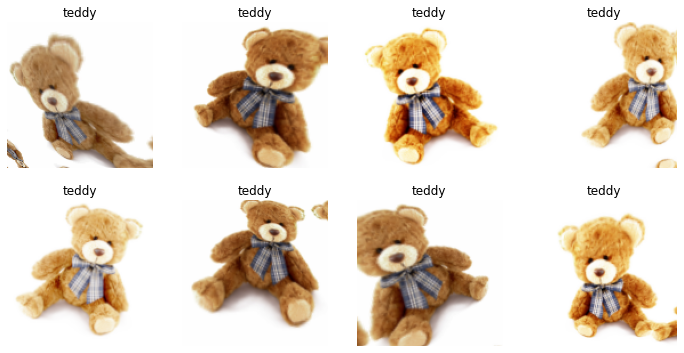

In [20]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.132349,0.092961,0.037975,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.147299,0.047035,0.012658,00:48
1,0.115966,0.024115,0.012658,00:55
2,0.086097,0.021983,0.012658,00:47
3,0.073044,0.016386,0.012658,01:00


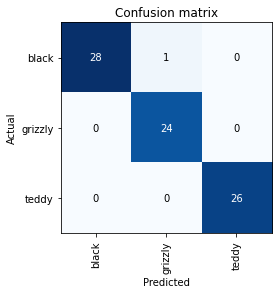

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

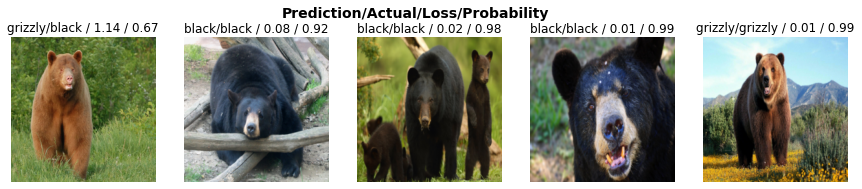

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [27]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([5.7725e-07, 1.0000e+00, 9.3195e-07]))

In [32]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [41]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [42]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [44]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.6 OK
